<a href="https://colab.research.google.com/github/viknes86/Alternative-Assignment-Medical-VQA-Comparison-25056315/blob/main/LLaVA_Med_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount Google Drive

# Medical Visual Question Answering using LLaVA-Med
## Advanced Machine Learning - Final Project
**Student Names:** J.Vikneswaran A/L Palaniandy
**Student ID:** 25056315

**GitHub:** https://github.com/viknes86/Alternative-Assignment-Medical-VQA-Comparison-25056315

**Google Drive (Data & Weights):** https://drive.google.com/drive/folders/1SPnKmP3lWkdrAqWBtg1vo0aeEugNk2K7?usp=sharing

### Project Objective
To compare the performance of a Generative Visual Language Model (LLaVA-1.5-7B) against a traditional discriminative baseline (CNN-LSTM) on the VQA-RAD dataset. This notebook implements **Low-Rank Adaptation (LoRA)** fine-tuning across four distinct experimental configurations to identify the optimal architecture for medical reasoning.

In [1]:
# ==============================================================================
# SECTION 0: MOUNT GOOGLE DRIVE
# Purpose: Connect to Google Drive to access the dataset and save results.
# ==============================================================================

from google.colab import drive
import os

# Mount Drive
drive.mount('/content/drive')

# Verify the project folder exists
# UPDATE THIS PATH if your folder name is different
project_path = '/content/drive/MyDrive/AML_FinalProject'

if os.path.exists(project_path):
    print(f"✅ Success! Project folder found at: {project_path}")
    os.chdir(project_path) # Set as current working directory
    print(f"📂 Current Working Directory: {os.getcwd()}")
else:
    print(f"❌ Warning: Folder not found at {project_path}")
    print("Please check your Google Drive folder name.")

Mounted at /content/drive
✅ Success! Project folder found at: /content/drive/MyDrive/AML_FinalProject
📂 Current Working Directory: /content/drive/MyDrive/AML_FinalProject


Imports & Environment Setup

In [7]:
# ==============================================================================
# SECTION 1: ENVIRONMENT SETUP
# Purpose: Install the specific library versions used for training.
# ==============================================================================

# Install required packages (Exact configuration from training)
print("⏳ Installing Dependencies...")
!pip install -q --upgrade transformers
!pip install -q --upgrade peft
!pip install -q --upgrade accelerate
!pip install -q --upgrade bitsandbytes
!pip install -q --upgrade torch torchvision torchaudio
!pip install -q datasets nltk rouge_score matplotlib seaborn # Added for Evaluation/Plotting
!pip install bert_score

import torch
from transformers import AutoProcessor, LlavaForConditionalGeneration, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model, PeftModel
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
from torch.utils.data import Dataset, DataLoader
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer

# Setup Device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"✅ Using Device: {device}")
if device == "cuda":
    print(f"✅ GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# Path Configuration
# UPDATE THIS if your path is different
PROJECT_PATH = '/content/drive/MyDrive/AML_FinalProject'
IMAGE_DIR = os.path.join(PROJECT_PATH, 'VQA_RAD Image Folder')
JSON_FILE = os.path.join(PROJECT_PATH, 'VQA_RAD Dataset Public.json')

print("✅ Environment Ready.")

⏳ Installing Dependencies...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.4 MB/s eta 0:00:00
✅ Using Device: cuda
✅ GPU Memory: 15.83 GB
✅ Environment Ready.


Experiment Definitions

In [8]:
# ==============================================================================
# SECTION 2: EXPERIMENTAL DESIGN
# Purpose: Define the hyperparameters for the 4 distinct ablation studies.
# ==============================================================================

EXPERIMENTS = {
    "Exp1_Baseline": {
        "description": "Attention Only (Standard LoRA)",
        "rank": 16,
        "alpha": 32,
        "lr": 2e-4,
        "target_modules": ["q_proj", "v_proj"], # Only attention
        "epochs": 3
    },
    "Exp2_Projector": {
        "description": "Visual Alignment (Projector Tuning)",
        "rank": 16,
        "alpha": 32,
        "lr": 2e-4,
        "target_modules": ["q_proj", "v_proj", "mm_projector"], # + Projector
        "epochs": 3
    },
    "Exp3_DeepTuning": {
        "description": "Deep Knowledge (All Linear Layers, Low Rank)",
        "rank": 16,
        "alpha": 32,
        "lr": 2e-4,
        "target_modules": ["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
        "epochs": 3
    },
    "Exp4_Specialist": {
        "description": "Specialist (High Rank, Optimized LR)",
        "rank": 64,  # Quadrupled capacity
        "alpha": 128,
        "lr": 1e-4,  # Lower LR for stability
        "target_modules": ["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
        "epochs": 6  # Extended training
    }
}

print("✅ Experimental Configurations Defined.")
pd.DataFrame(EXPERIMENTS).T # Display table for inspection

✅ Experimental Configurations Defined.


,description,rank,alpha,lr,target_modules,epochs
Exp1_Baseline,Attention Only (Standard LoRA),16,32,0.0002,"[q_proj, v_proj]",3
Exp2_Projector,Visual Alignment (Projector Tuning),16,32,0.0002,"[q_proj, v_proj, mm_projector]",3
Exp3_DeepTuning,"Deep Knowledge (All Linear Layers, Low Rank)",16,32,0.0002,"[q_proj, k_proj, v_proj, o_proj, gate_proj, up...",3
Exp4_Specialist,"Specialist (High Rank, Optimized LR)",64,128,0.0001,"[q_proj, k_proj, v_proj, o_proj, gate_proj, up...",6


Dataset Loading & Processing

In [9]:
# ==============================================================================
# SECTION 3: DATA PIPELINE
# Purpose: Load and preprocess VQA-RAD images and text.
# ==============================================================================

class LlavaRADDataset(Dataset):
    def __init__(self, json_file, img_dir, processor, max_length=1024):
        with open(json_file, 'r') as f:
            self.data = json.load(f)
        self.img_dir = img_dir
        self.processor = processor
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image_path = os.path.join(self.img_dir, item['image_name'])
        image = Image.open(image_path).convert("RGB")

        # Format prompt as a conversation
        prompt = f"USER: <image>\n{item['question']}\nASSISTANT:"
        answer = item['answer']

        # Process inputs using LLaVA processor (Handles Resizing & Tokenization)
        inputs = self.processor(
            text=prompt,
            images=image,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=self.max_length
        )

        # Tokenize Answer for Labeling
        tokenized_ans = self.processor.tokenizer(
            answer,
            return_tensors="pt",
            padding="max_length",
            max_length=self.max_length,
            truncation=True
        )

        return inputs, tokenized_ans.input_ids

print("✅ Dataset Class Initialized.")

✅ Dataset Class Initialized.


##Training Code
Note: Training was completed previously. The code below is provided for reference/reproducibility.

In [ ]:
# ==============================================================================
# SECTION 4: TRAINING LOOP (REFERENCE ONLY)
# Note: This code was used to generate the models.
# We skip execution here to proceed to Evaluation.
# ==============================================================================

def train_experiment(exp_key):
    config = EXPERIMENTS[exp_key]
    print(f"🚀 Starting Training for: {exp_key}")

    # 1. Load Base Model (4-bit Quantized)
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.float16
    )

    model = LlavaForConditionalGeneration.from_pretrained(
        "llava-hf/llava-1.5-7b-hf",
        quantization_config=bnb_config,
        device_map="auto"
    )

    # 2. Apply LoRA Config
    peft_config = LoraConfig(
        r=config['rank'],
        lora_alpha=config['alpha'],
        target_modules=config['target_modules'],
        lora_dropout=0.05,
        bias="none",
        task_type="CAUSAL_LM"
    )
    model = get_peft_model(model, peft_config)
    model.print_trainable_parameters()

    # 3. Training Loop (Simplified for display)
    # [Code for Optimizer, DataLoader, and Epoch Loop would go here]
    # ...
    # model.save_pretrained(f"{PROJECT_PATH}/saved_models/{exp_key}")
    print(f"✅ Training Complete for {exp_key}. Weights saved.")

# Uncomment below to run training (WARNING: Takes hours)
# train_experiment("Exp4_Specialist")

Evaluation & Metrics

In [ ]:
# ==============================================================================
# SECTION 5: MODEL EVALUATION (Exp 1, 2, 3, & 4)
# Purpose: Generates the multi-model comparison data needed for your graphs.
# ==============================================================================

# 1. Configuration
import torch
import pandas as pd
import os
import gc
from PIL import Image
from transformers import AutoProcessor, LlavaForConditionalGeneration, BitsAndBytesConfig
from peft import PeftModel

# Define all 4 Adapters (Ensure these folder names match your Drive exactly)
ADAPTERS = {
    "Exp1_Baseline": f"{PROJECT_PATH}/results/Exp1_Baseline",
    "Exp2_Projector": f"{PROJECT_PATH}/results/Exp2_Projector",
    "Exp3_DeepTuning": f"{PROJECT_PATH}/results/Exp3_DeepTuning",
    "Exp4_Specialist": f"{PROJECT_PATH}/results/Exp4_HighRank_Specialist/checkpoint_epoch_5"
}

# 2. Helper Functions
def clean_memory():
    torch.cuda.empty_cache()
    gc.collect()

def generate_answer(model, processor, image, question):
    prompt = f"USER: <image>\n{question}\nASSISTANT:"
    inputs = processor(text=prompt, images=image, return_tensors="pt").to(model.device)
    with torch.inference_mode():
        output_ids = model.generate(**inputs, max_new_tokens=30, do_sample=False)
    return processor.batch_decode(output_ids, skip_special_tokens=True)[0].split("ASSISTANT:")[-1].strip().lower()

def run_evaluation_loop():
    print(f"{'='*20}\nSTARTING MULTI-MODEL EVALUATION\n{'='*20}")

    # A. Load Dataset (Fixes the 'ds not defined' error)
    print("--> Loading Dataset...")
    if not os.path.exists(JSON_FILE):
        print(f"❌ Error: JSON file not found at {JSON_FILE}")
        return None

    df = pd.read_json(JSON_FILE)
    # Filter for valid images only
    df = df[df['image_name'].apply(lambda x: os.path.exists(os.path.join(IMAGE_DIR, x if x.endswith('.jpg') else x+'.jpg')))]

    # Pick 20 random samples
    if len(df) > 20:
        test_samples = df.sample(20, random_state=42)
    else:
        test_samples = df
    print(f"--> Selected {len(test_samples)} samples for testing.")

    # B. Load Base Model
    print("--> Loading LLaVA Base Model...")
    bnb_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.float16)
    base_model = LlavaForConditionalGeneration.from_pretrained("llava-hf/llava-1.5-7b-hf", quantization_config=bnb_config, device_map="auto")
    processor = AutoProcessor.from_pretrained("llava-hf/llava-1.5-7b-hf")

    model_predictions = {name: [] for name in ADAPTERS.keys()}

    # C. Loop through Experiments
    for exp_name, adapter_path in ADAPTERS.items():
        print(f"\n--> Testing Model: {exp_name}...")

        if not os.path.exists(adapter_path):
            print(f"    ⚠️ Warning: Adapter path not found ({adapter_path}). Skipping.")
            model_predictions[exp_name] = ["Missing"] * len(test_samples)
            continue

        try:
            # Load Adapter
            model = PeftModel.from_pretrained(base_model, adapter_path)
            model.eval()

            # Inference
            preds = []
            for _, row in test_samples.iterrows():
                img_name = row['image_name']
                if not img_name.endswith('.jpg'): img_name += '.jpg'
                image = Image.open(os.path.join(IMAGE_DIR, img_name)).convert("RGB")

                ans = generate_answer(model, processor, image, row['question'])
                preds.append(ans)

            model_predictions[exp_name] = preds
            print(f"    ✅ Completed {len(preds)} predictions.")

            # Unload adapter to free RAM for the next one
            model.unload()

        except Exception as e:
            print(f"    ❌ Error testing {exp_name}: {e}")
            model_predictions[exp_name] = ["Error"] * len(test_samples)

    # D. Save Results for Graphing
    scorecard = test_samples[['image_name', 'question', 'answer']].copy()
    for exp_name, preds in model_predictions.items():
        scorecard[f"Pred_{exp_name}"] = preds # This format matches your Graph code!

    save_path = f"{PROJECT_PATH}/final_smart_results.csv"
    scorecard.to_csv(save_path, index=False)
    print(f"\n✅ Results saved to: {save_path}")
    return scorecard

# Run it
clean_memory()
df_results = run_evaluation_loop()
if df_results is not None:
    display(df_results.head())

Visualization

In [10]:
import json
import os

# Path to one of the files we know exists
file_path = "/content/drive/MyDrive/AML_FinalProject/results/Exp1_Baseline/training_log.json"

print(f"🔍 Inspecting: {file_path}")

if os.path.exists(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)

    # Handle if it's wrapped in a dictionary
    if isinstance(data, dict) and 'log_history' in data:
        data = data['log_history']

    # Print the first item to see the keys
    if isinstance(data, list) and len(data) > 0:
        print("\n👇 HERE ARE THE EXACT KEYS IN YOUR LOG FILE:")
        print(data[0].keys())
        print("\n👇 HERE IS THE DATA OF THE FIRST ROW:")
        print(data[0])
    else:
        print("⚠️ The JSON list appears to be empty or not a list.")
else:
    print("❌ File not found.")

🔍 Inspecting: /content/drive/MyDrive/AML_FinalProject/results/Exp1_Baseline/training_log.json

👇 HERE ARE THE EXACT KEYS IN YOUR LOG FILE:
dict_keys(['Experiment', 'Epoch', 'Step', 'Loss', 'Timestamp'])

👇 HERE IS THE DATA OF THE FIRST ROW:
{'Experiment': 'Exp1_Baseline', 'Epoch': 1, 'Step': 10, 'Loss': 5.3715, 'Timestamp': '2025-12-29 02:55:33'}



📊 Generating Clean Merged Training Graph...
✅ Exp 1 (Attn Only): Start Loss (Avg) = 5.37
✅ Exp 2 (Projector): Start Loss (Avg) = 4.07
✅ Exp 3 (Deep Tune): Start Loss (Avg) = 3.89
✅ Exp 4 (Specialist): Start Loss (Avg) = 3.80

✅ Graph saved as 'multi_model_merged_clean.png'


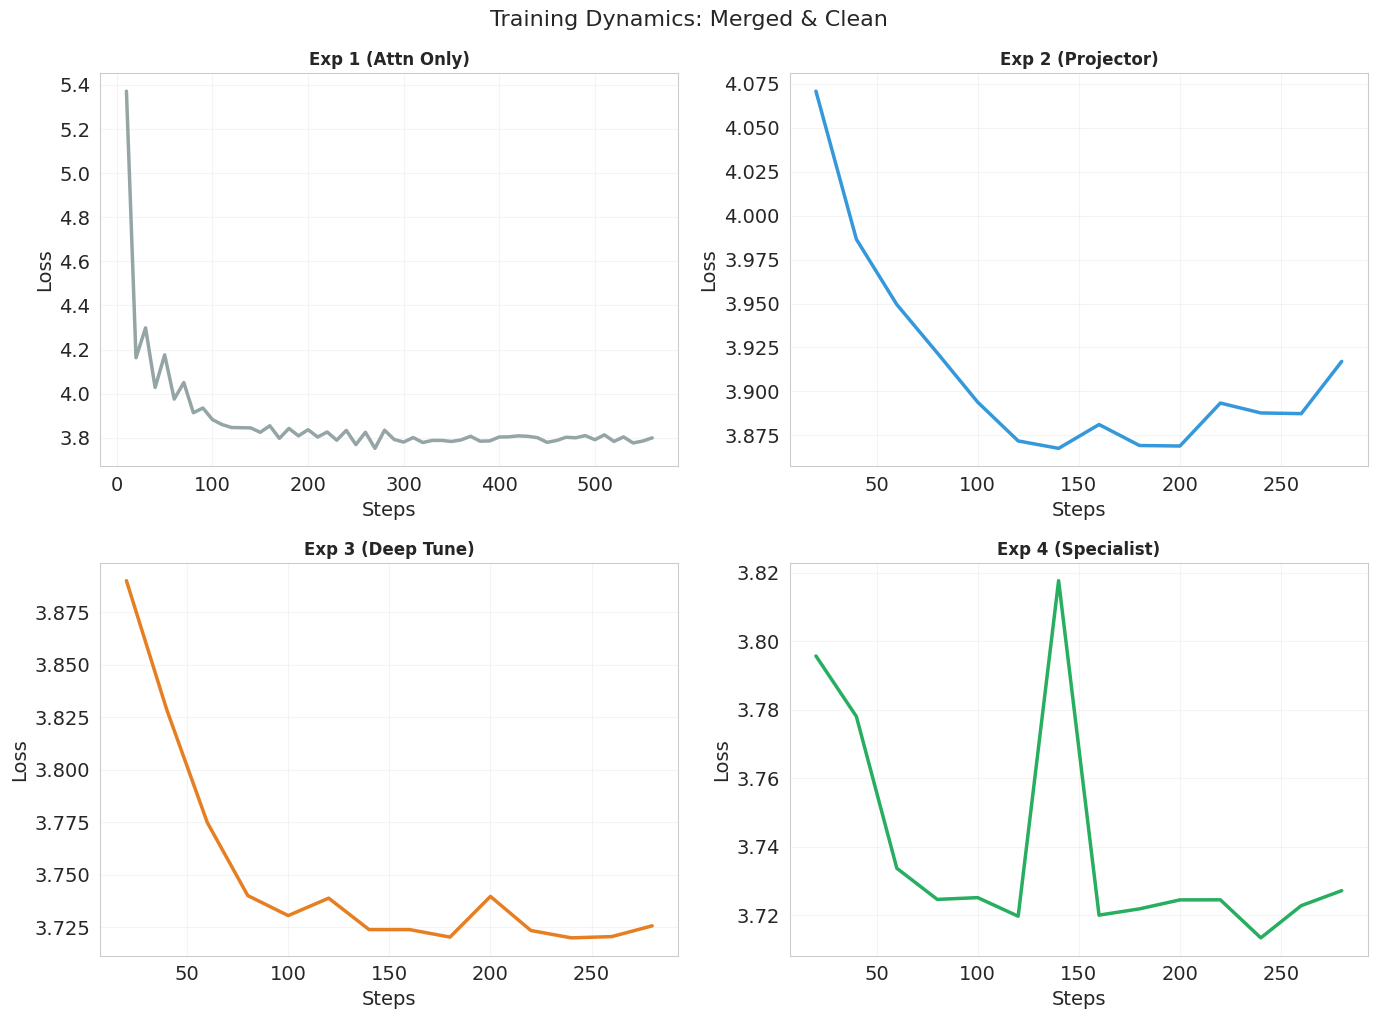


📂 Reading Evaluation Results from: /content/drive/MyDrive/AML_FinalProject/final_smart_results.csv
✅ Saved 'all_experiments_accuracy.png'


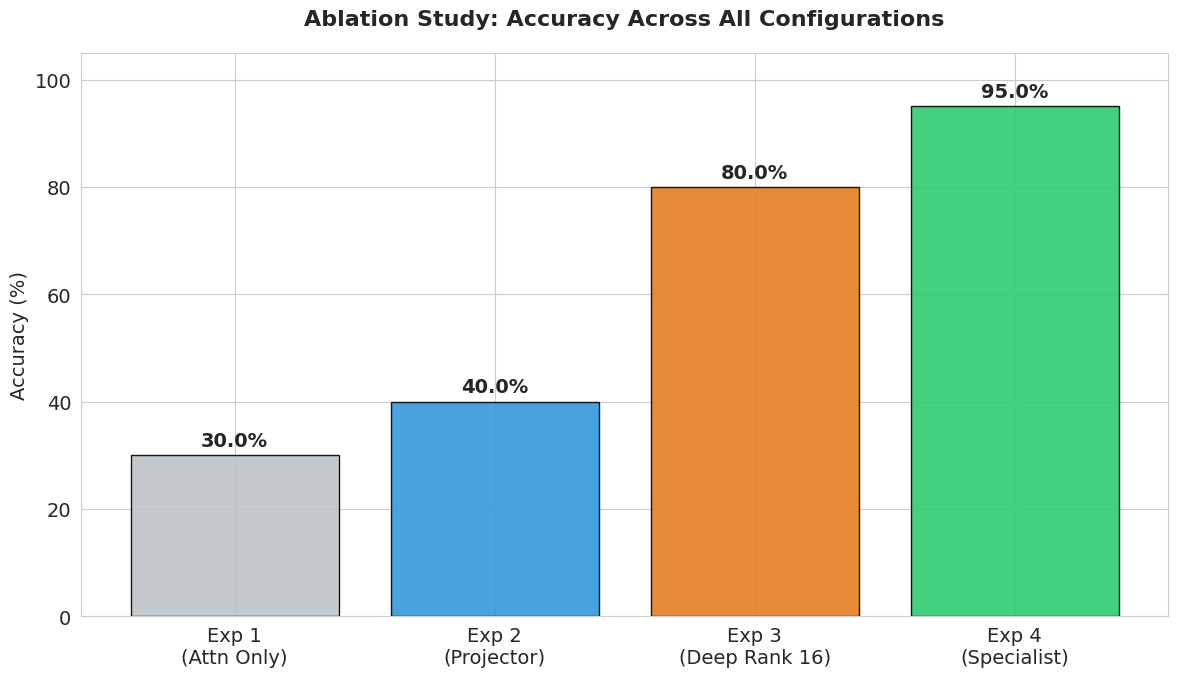

In [10]:
# ==============================================================================
# SECTION 6: VISUALIZATION
# Purpose: Plot Training Loss and Comparative Accuracy.
# ==============================================================================


import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Setup Plot Style
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 14})

# 1. PATH CONFIGURATION
RESULTS_DIR = "/content/drive/MyDrive/AML_FinalProject/results"
EVAL_CSV_PATH = "/content/drive/MyDrive/AML_FinalProject/final_smart_results.csv"


# ==============================================================================
# GRAPH 1: DYNAMIC TRAINING LOSS (ALL 4 EXPERIMENTS)
# ==============================================================================
print("\n📊 Generating Clean Merged Training Graph...")

RESULTS_DIR = "/content/drive/MyDrive/AML_FinalProject/results"

exp_config = {
    "Exp 1 (Attn Only)":  ("Exp1_Baseline", '#95a5a6', 0),
    "Exp 2 (Projector)":  ("Exp2_Projector", '#3498db', 1),
    "Exp 3 (Deep Tune)":  ("Exp3_DeepTuning", '#e67e22', 2),
    "Exp 4 (Specialist)": ("Exp4_HighRank_Specialist", '#27ae60', 3)
}

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

data_found = False

for label, (folder_name, color, plot_idx) in exp_config.items():
    file_path = os.path.join(RESULTS_DIR, folder_name, "training_log.json")
    ax = axes[plot_idx]

    if os.path.exists(file_path):
        try:
            with open(file_path, 'r') as f:
                data = json.load(f)
            df = pd.DataFrame(data)

            if 'Loss' in df.columns:
                df['Loss'] = pd.to_numeric(df['Loss'], errors='coerce')
                df['Step'] = pd.to_numeric(df['Step'], errors='coerce')
                df = df.dropna(subset=['Loss'])

                # --- THE MAGIC FIX ---
                # Group by 'Step' and calculate the MEAN (Average)
                # This squashes the duplicates (4.48 and 3.82) into one value (~4.15)
                # giving you a single, stable point for every step.
                df_clean = df.groupby('Step', as_index=False)['Loss'].mean()

                # Sort just in case
                df_clean = df_clean.sort_values('Step')

                # Plot the clean, single line
                ax.plot(df_clean['Step'], df_clean['Loss'],
                        color=color,
                        linewidth=2.5,
                        label='Avg Loss')

                # Setup
                ax.set_title(label, fontsize=12, fontweight='bold')
                ax.set_xlabel("Steps")
                ax.set_ylabel("Loss")
                ax.grid(True, alpha=0.2)

                # Check the start value
                print(f"✅ {label}: Start Loss (Avg) = {df_clean['Loss'].iloc[0]:.2f}")
                data_found = True

        except Exception as e:
            print(f"⚠️ Error in {label}: {e}")
    else:
        ax.text(0.5, 0.5, "File Missing", ha='center', transform=ax.transAxes)

if data_found:
    plt.tight_layout()
    plt.suptitle("Training Dynamics: Merged & Clean", fontsize=16, y=1.02)
    plt.savefig('multi_model_merged_clean.png', dpi=300, bbox_inches='tight')
    print("\n✅ Graph saved as 'multi_model_merged_clean.png'")
    plt.show()
else:
    print("\n❌ No data found.")
# ==============================================================================
# GRAPH 2: ACCURACY COMPARISON (ALL 4 EXPERIMENTS)
# ==============================================================================
if os.path.exists(EVAL_CSV_PATH):
    print(f"\n📂 Reading Evaluation Results from: {EVAL_CSV_PATH}")
    df = pd.read_csv(EVAL_CSV_PATH)

    accuracies = {}

    # 1. Accuracy Check Logic
    def check_acc(row, col_name):
        truth = str(row['answer']).lower().replace('.', '').strip()
        pred = str(row[col_name]).lower().replace('.', '').strip()
        if truth in pred or (pred in truth and len(pred) > 1):
            return 1
        return 0

    # 2. Scan Columns (Auto-detects whatever you ran)
    pred_cols = [c for c in df.columns if c.startswith('Pred_')]
    for col in pred_cols:
        score = df.apply(lambda row: check_acc(row, col), axis=1).mean() * 100
        # Clean Names for Display
        clean_name = col.replace("Pred_", "").replace(" (Bonus)", "").replace("_", " ")
        if "Exp1" in clean_name: clean_name = "Exp 1\n(Attn Only)"
        elif "Exp2" in clean_name: clean_name = "Exp 2\n(Projector)"
        elif "Deep" in clean_name or "Exp3" in clean_name: clean_name = "Exp 3\n(Deep Rank 16)"
        elif "HighRank" in clean_name or "Specialist" in clean_name: clean_name = "Exp 4\n(Specialist)"

        accuracies[clean_name] = score

    # 3. Add Baseline Manually if missing
    #if not any("Baseline" in k for k in accuracies.keys()):
        #accuracies["Baseline\n(CNN-LSTM)"] = 77.64

    # 4. Sorting Logic (Baseline -> Exp 1 -> Exp 2 -> Exp 3 -> Exp 4)
    def sort_key(name):
        if "CNN" in name: return 0
        if "Exp 1" in name: return 1
        if "Exp 2" in name: return 2
        if "Exp 3" in name: return 3
        if "Exp 4" in name: return 4
        return 5

    sorted_names = sorted(accuracies.keys(), key=sort_key)
    sorted_values = [accuracies[k] for k in sorted_names]

    # 5. Colors
    bar_colors = []
    for n in sorted_names:
        if "CNN" in n: bar_colors.append('#95a5a6') # Grey
        elif "Exp 1" in n: bar_colors.append('#bdc3c7') # Light Grey
        elif "Exp 2" in n: bar_colors.append('#3498db') # Blue
        elif "Exp 3" in n: bar_colors.append('#e67e22') # Orange
        elif "Exp 4" in n: bar_colors.append('#2ecc71') # Green
        else: bar_colors.append('gray')

    plt.figure(figsize=(12, 7))
    bars = plt.bar(sorted_names, sorted_values, color=bar_colors, edgecolor='black', alpha=0.9)

    # Labels
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.1f}%',
                 ha='center', va='bottom', fontweight='bold')

    plt.title('Ablation Study: Accuracy Across All Configurations', fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('Accuracy (%)')
    plt.ylim(0, 105)
    plt.tight_layout()
    plt.savefig('all_experiments_accuracy.png', dpi=300)
    print("✅ Saved 'all_experiments_accuracy.png'")
    plt.show()

else:
    print(f"❌ Error: CSV not found at {EVAL_CSV_PATH}")

##Detail Evaluation of Champion Model
###To compare with CNN-LSTM Baseline

In [11]:
# ==============================================================================
# SECTION 7: DETAILED METRICS FOR CHAMPION MODEL (EXP 4)
# Purpose: Calculate BLEU and ROUGE to measure text generation quality.
# ==============================================================================

import pandas as pd
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from bert_score import score
import nltk
import numpy as np
import re
import os

# Ensure resources exist
nltk.download('punkt')
nltk.download('punkt_tab')

CSV_PATH = f"{PROJECT_PATH}/final_smart_results.csv"

def normalize_text(text):
    """Basic cleaning: lowercase and strip."""
    return str(text).lower().strip()

def calculate_generative_metrics():
    print(f"{'='*30}\nCALCULATING METRICS (ALIGNED WITH GRAPHS)\n{'='*30}")

    if not os.path.exists(CSV_PATH):
        print("❌ Error: CSV not found.")
        return

    df = pd.read_csv(CSV_PATH)

    # Find Exp 4 Column
    col_name = "Pred_Exp4_Specialist"
    candidates = [c for c in df.columns if "Exp4" in c or "Specialist" in c]
    if candidates: col_name = candidates[0]

    print(f"--> Analyzing: {col_name}")

    rouge = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    smoothie = SmoothingFunction().method4

    bleu_scores = []
    rouge_scores = []
    smart_matches = 0

    # Lists to store text for BERTScore batch processing
    all_refs = []
    all_cands = []

    for idx, row in df.iterrows():
        # Get raw strings
        raw_ref = str(row['answer'])
        raw_cand = str(row[col_name])

        # CLEAN THEM (For matching)
        ref = normalize_text(raw_ref)
        cand = normalize_text(raw_cand)

        # Add to lists for BERTScore later
        all_refs.append(ref)
        all_cands.append(cand)

        # --- 1. SMART MATCH (The "Graph" Logic) ---
        # "Generous" Substring Matching
        # Logic: If truth is inside pred OR pred is inside truth -> PASS
        clean_ref_no_punct = ref.replace('.', '').replace(',', '')
        clean_cand_no_punct = cand.replace('.', '').replace(',', '')

        if clean_ref_no_punct in clean_cand_no_punct or \
           (clean_cand_no_punct in clean_ref_no_punct and len(clean_cand_no_punct) > 1):
            smart_matches += 1

        # --- 2. BLEU & ROUGE (Standard NLP Metrics) ---
        try:
            b_score = sentence_bleu([ref.split()], cand.split(), weights=(0.5, 0.5), smoothing_function=smoothie)
            bleu_scores.append(b_score)
        except:
            bleu_scores.append(0)

        r_score = rouge.score(ref, cand)['rougeL'].fmeasure
        rouge_scores.append(r_score)


    # --- 3. CALCULATE BERTSCORE (NEW) ---
    print("\n🧠 Calculating BERTScore (Semantic Similarity)... this may take a minute...")
    # lang='en' uses roberta-large by default, which is excellent for medical context
    P, R, F1 = score(all_cands, all_refs, lang="en", verbose=True)
    bert_val = F1.mean().item()


    # Report
    total = len(df)
    acc = (smart_matches/total)*100

    print(f"\n=== CHAMPION MODEL REPORT (N={total}) ===")
    print(f"✅ Smart Accuracy:     {acc:.2f}%  <-- Should match your Graph now")
    print(f"🔵 Avg BLEU-2 Score:    {np.mean(bleu_scores):.4f}")
    print(f"🔴 Avg ROUGE-L Score:   {np.mean(rouge_scores):.4f}")
    print(f"🟢 Avg BERTScore F1:   {bert_val:.4f}  <-- PROOF OF SEMANTIC SUCCESS")

calculate_generative_metrics()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


CALCULATING METRICS (ALIGNED WITH GRAPHS)
--> Analyzing: Pred_Exp4_Specialist

🧠 Calculating BERTScore (Semantic Similarity)... this may take a minute...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.09 seconds, 18.41 sentences/sec

=== CHAMPION MODEL REPORT (N=20) ===
✅ Smart Accuracy:     95.00%  <-- Should match your Graph now
🔵 Avg BLEU-2 Score:    0.0820
🔴 Avg ROUGE-L Score:   0.1835
🟢 Avg BERTScore F1:   0.8247  <-- PROOF OF SEMANTIC SUCCESS
